# Initialize

In [1]:
import os
init=False

# Imports

In [2]:
if not init:
    os.chdir('..')
    init=True
from pythonfigures.datapartition import DataPartitioner
from pythonfigures.neuraldatabase import Query
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from scipy.linalg import subspace_angles, null_space, orth

import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import iplot
from plotly.subplots import make_subplots

from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import colors

from typing import Optional

# Get Data

In [3]:
dp = DataPartitioner(session='Zara70',
                    areas=['AIP'],
                    aligns=['fixation','cue onset','go cue onset','movement onset','hold'],
                    contexts=['active','passive'],
                    groupings=['context','alignment','grip','object','turntable','time'])

print( dp.get('groupings') )

[[], ['context'], ['alignment'], ['context', 'alignment'], ['grip'], ['context', 'grip'], ['alignment', 'grip'], ['context', 'alignment', 'grip'], ['object'], ['context', 'object'], ['alignment', 'object'], ['context', 'alignment', 'object'], ['grip', 'object'], ['context', 'grip', 'object'], ['alignment', 'grip', 'object'], ['context', 'alignment', 'grip', 'object'], ['turntable'], ['context', 'turntable'], ['alignment', 'turntable'], ['context', 'alignment', 'turntable'], ['grip', 'turntable'], ['context', 'grip', 'turntable'], ['alignment', 'grip', 'turntable'], ['context', 'alignment', 'grip', 'turntable'], ['object', 'turntable'], ['context', 'object', 'turntable'], ['alignment', 'object', 'turntable'], ['context', 'alignment', 'object', 'turntable'], ['grip', 'object', 'turntable'], ['context', 'grip', 'object', 'turntable'], ['alignment', 'grip', 'object', 'turntable'], ['context', 'alignment', 'grip', 'object', 'turntable'], ['time'], ['context', 'time'], ['alignment', 'time'],

In [4]:
# query the whole damn thing
df = dp.readQuery(0)

# convert from turntable x object ID vs. just the turntable ID
df['turntable'] = df['turntable'] // 10

print(df)

         n0        n1   n2   n3   n4   n5        n6        n7        n8   n9  \
0       0.0  0.093237  0.0  0.0  0.0  0.0  0.133653  0.015111  0.393682  0.0   
1       0.0  0.061866  0.0  0.0  0.0  0.0  0.188941  0.008631  0.397735  0.0   
2       0.0  0.039524  0.0  0.0  0.0  0.0  0.256995  0.004737  0.409651  0.0   
3       0.0  0.024301  0.0  0.0  0.0  0.0  0.336347  0.002498  0.429751  0.0   
4       0.0  0.014378  0.0  0.0  0.0  0.0  0.423572  0.001265  0.457440  0.0   
...     ...       ...  ...  ...  ...  ...       ...       ...       ...  ...   
189595  0.0  0.088819  0.0  0.0  0.0  0.0  0.642498  0.000000  0.174741  0.0   
189596  0.0  0.059543  0.0  0.0  0.0  0.0  0.671860  0.000000  0.156003  0.0   
189597  0.0  0.038364  0.0  0.0  0.0  0.0  0.681889  0.000000  0.136226  0.0   
189598  0.0  0.023778  0.0  0.0  0.0  0.0  0.671674  0.000000  0.116920  0.0   
189599  0.0  0.014226  0.0  0.0  0.0  0.0  0.642016  0.000000  0.099724  0.0   

        ...      n118  n119      n120  

# Visualize the problem

In [5]:
# get baseline effects (i.e., before even fixation)
df_fixation = df[(df['alignment']=='fixation') & (df['time']>0)].groupby(['context','turntable','object','grip'])[dp.get('neuronColumnNames')].aggregate('mean')

# get vision-period effects (i.e., after cue onset)
df_vision = df[(df['alignment']=='cue onset') & (df['time']>0)].groupby(['context','turntable','object','grip'])[dp.get('neuronColumnNames')].aggregate('mean')

# get movement-period effects (post-movement onset, skip the preparatory activity which is more grip-agnostic than the movement-period activity per se, at least in M1)
df_movement = df[(df['alignment']=='movement onset') & (df['time']>0)].groupby(['context','turntable','object','grip'])[dp.get('neuronColumnNames')].aggregate('mean')

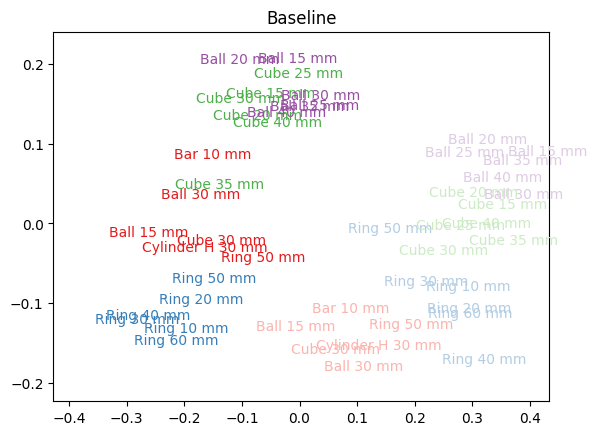

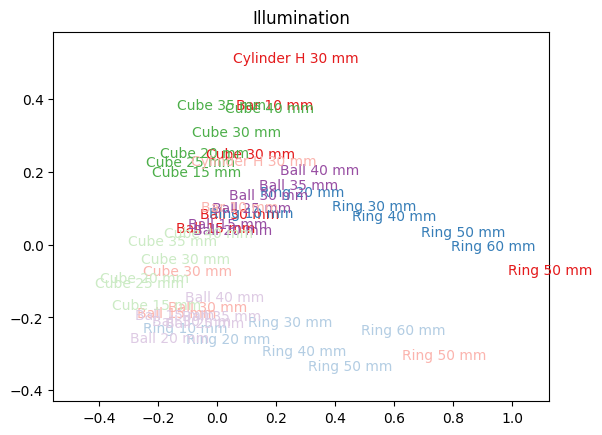

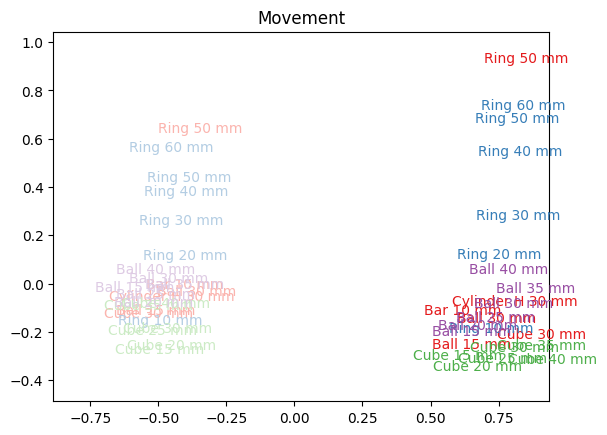

In [6]:
# make plots
df_list = [df_fixation,df_vision,df_movement]
align_names = ['Baseline','Illumination','Movement']

for idx,df_ in enumerate(df_list):
    index_levels      = df_.index.to_list()
    unique_turntables = df_.index.unique(1).to_list()

    marker_color_indices = np.array([unique_turntables.index(x[1]) for x in index_levels])

    context_names = df_fixation.index.unique(0).to_list()
    marker_colormap_indices = np.array([context_names.index(x[0]) for x in index_levels])

    cmaps = [cm.Set1,cm.Pastel1]
    
    # PCA model
    pcmdl = PCA(n_components=2)
    pcmdl.fit(df_.to_numpy())
    xt    = pcmdl.transform(df_.to_numpy()) # "X transformed" where "X" is just a general name for a data matrix

    marker_x_positions = xt[:,0]
    marker_y_positions = xt[:,1]

    xl = [min(marker_x_positions),max(marker_x_positions)]
    delx = xl[1]-xl[0]
    xl[0] = xl[0]-0.1*delx
    xl[1] = xl[1]+0.1*delx

    yl = [min(marker_y_positions),max(marker_y_positions)]
    dely = yl[1]-yl[0]
    yl[0] = yl[0]-0.1*dely
    yl[1] = yl[1]+0.1*dely

    plt.figure()
    for contextind in range(len(context_names)):
        mx = marker_x_positions[marker_colormap_indices==contextind]
        my = marker_y_positions[marker_colormap_indices==contextind]
        mc = marker_color_indices[marker_colormap_indices==contextind]
        objnames = [x[2] for x in index_levels if x[0]==context_names[contextind]]

        for objind in range(len(objnames)):
            plt.text(x=mx[objind],
                     y=my[objind],
                     s=objnames[objind],
                     color=cmaps[contextind].colors[mc[objind]])

    plt.xlim(xl)
    plt.ylim(yl)
    plt.title(align_names[idx])
    # plt.axis('off')
    plt.show()
    

# First, we need to remove any context & object information in the baseline

In [7]:
# iterate removal of axes until performance is within one standard error of chance
df_fixation_trials = df[(df['alignment']=='fixation') & (df['time']>0)].groupby(['context','turntable','trial'])[dp.get('neuronColumnNames')].aggregate('mean')

flag        = False
removeSpace = None
X           = df_fixation_trials.to_numpy()
y_context   = df_fixation_trials.index.get_level_values(0).to_numpy()
y_turntable = df_fixation_trials.index.get_level_values(1).to_numpy()
y_combined  = np.array( [f'{y_context[idx]} {y_turntable[idx]}' for idx in range(len(y_context))] )
N           = len(y_combined)
neurcount   = df_fixation_trials.shape[1]
pccount     = 30

# partition into training and test sets
train = dict()
test  = dict()
train['X'],test['X'],train['y'],test['y'] = train_test_split(X,y_combined,
                                                             test_size=0.2,
                                                             train_size=None,
                                                             stratify=y_combined)

# fit a PCA model
PCAmdl = PCA(n_components=pccount)
PCAmdl.fit(train['X'])
train['X_transform'] = PCAmdl.transform(train['X'])
test['X_transform']  = PCAmdl.transform(test['X'])
ntest                = len(test['y'])

while not flag:
    flag = True
    if removeSpace is not None:
        projspace = null_space( np.matrix(removeSpace) )
    else:
        projspace = np.identity(pccount)
    
    # I feel like there has to be a problem here...
    Xtrain = train['X_transform'] @ projspace
    Xtest  = test['X_transform'] @ projspace
    
    # context, turntable, compound classification problems
    for idx in range(3):
        LDAmdl = LDA()
        
        ytrain = train['y']
        ytest  = test['y']
        
        # get the right labels
        if idx>1:
            pass
        else:
            ytrain = np.array( [y_.split()[idx] for y_ in ytrain] )
            ytest  = np.array( [y_.split()[idx] for y_ in ytest] )
        
        LDAmdl.fit(X=Xtrain,y=ytrain)
        yhat   = LDAmdl.predict(X=Xtest)
        acc    = np.mean(yhat == ytest)
        chance = max(LDAmdl.priors_)
        
        # assess performance, add to the removed subspace if it's 2 SEs better than chance
        if acc > (chance + 2*np.sqrt(chance*(1-chance)/ntest) ):
            # get the first axis of the LDA model
            
            # for getting rid of PCs instead
            # tempPC = PCA(n_components=1)
            # tempPC.fit(Xtrain)
            # ax = np.matrix(tempPC.components_)
            
            ax = np.matrix( LDAmdl.coef_[0,:] )
            
            if removeSpace is not None:
                # re-project into the original space
                ax = ax @ projspace.T
                removeSpace = np.vstack((removeSpace,ax))
            else:
                removeSpace = ax
            
            if removeSpace.shape[0]<np.Infinity:
                flag = False
                
            break

removeSpace dimensionality: 21


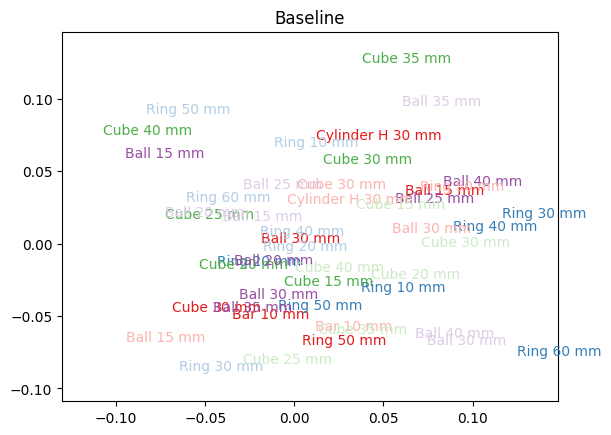

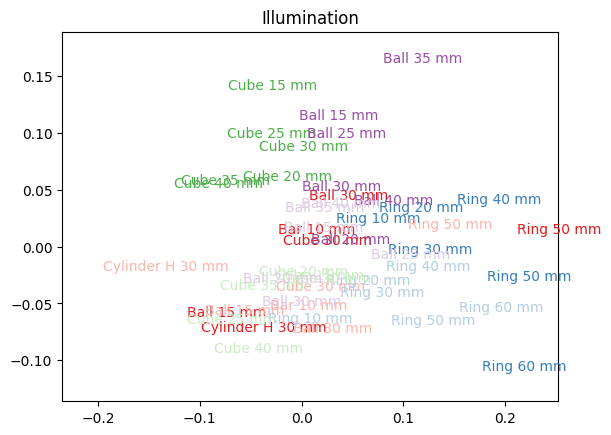

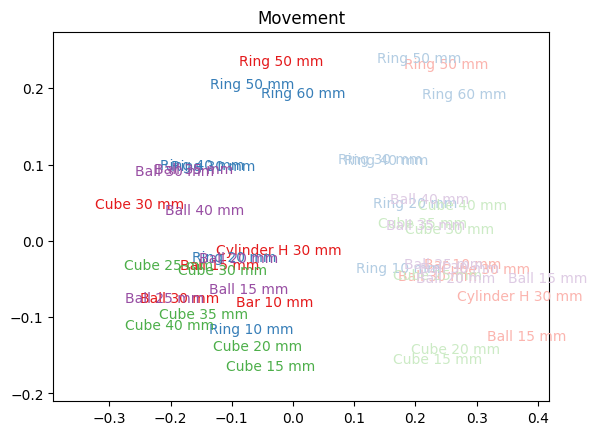

In [8]:
# now go back to the pca plots
df_list = [df_fixation,df_vision,df_movement]
align_names = ['Baseline','Illumination','Movement']

print(f"removeSpace dimensionality: {np.linalg.matrix_rank(np.matrix(removeSpace))}")

for idx,df_ in enumerate(df_list):
    index_levels      = df_.index.to_list()
    unique_turntables = df_.index.unique(1).to_list()

    marker_color_indices = np.array([unique_turntables.index(x[1]) for x in index_levels])

    context_names = df_fixation.index.unique(0).to_list()
    marker_colormap_indices = np.array([context_names.index(x[0]) for x in index_levels])

    cmaps = [cm.Set1,cm.Pastel1]
    
    # PCA model (use the one you just used for the problem above! otherwise it ain't right!)
    xt    = PCAmdl.transform(df_.to_numpy()) # "X transformed" where "X" is just a general name for a data matrix
        
    # project onto the nullspace of what you just found
    xt = xt @ null_space( np.matrix(removeSpace) )
    
    # and redo PCA!
    pcmdl = PCA(n_components=2)
    pcmdl.fit(xt)
    xt    = pcmdl.transform(xt)
    
    marker_x_positions = xt[:,0]
    marker_y_positions = xt[:,1]

    xl = [min(marker_x_positions),max(marker_x_positions)]
    delx = xl[1]-xl[0]
    xl[0] = xl[0]-0.1*delx
    xl[1] = xl[1]+0.1*delx

    yl = [min(marker_y_positions),max(marker_y_positions)]
    dely = yl[1]-yl[0]
    yl[0] = yl[0]-0.1*dely
    yl[1] = yl[1]+0.1*dely

    plt.figure()
    for contextind in range(len(context_names)):
        mx = marker_x_positions[marker_colormap_indices==contextind]
        my = marker_y_positions[marker_colormap_indices==contextind]
        mc = marker_color_indices[marker_colormap_indices==contextind]
        objnames = [x[2] for x in index_levels if x[0]==context_names[contextind]]

        for objind in range(len(objnames)):
            plt.text(x=mx[objind],
                     y=my[objind],
                     s=objnames[objind],
                     color=cmaps[contextind].colors[mc[objind]])

    plt.xlim(xl)
    plt.ylim(yl)
    plt.title(align_names[idx])
    # plt.axis('off')
    plt.show()
    
# ughhhh this is removing WAY too many dimensions!
# I should use a variance criterion, NOT a classification one!
# you know, like I *already* established for the current draft of the paper???

In [9]:
print(removeSpace.shape)

(21, 30)


# Now, verify that classification of (visual) objects or (movement) grips is unaffected by the removal of this subspace